In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
COMPANY = 'pkn'

In [3]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [4]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [5]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('pkn_m.csv')

In [6]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [7]:
peo_roll_beta

array([0.96741153, 0.96982935, 0.95011095, 1.09958231, 1.16862337,
       1.13459742, 1.14194265, 1.15726181, 1.12772388, 1.1105736 ,
       1.1138578 , 1.11862132, 1.13150836, 1.1375411 , 1.15180667,
       1.10552502, 1.10656651, 1.10388783, 1.09376852, 1.10486779,
       1.18194164, 1.11047588, 1.12713476, 1.16081385, 1.16559972,
       1.16142674, 1.16779862, 1.17356173, 1.03089019, 0.93788915,
       0.95953821, 0.95193808, 0.96810992, 0.94070256, 0.97530962,
       0.93394606, 0.91898097, 0.90360467, 0.84726727, 0.82545087,
       0.82364202, 0.84335704, 0.83348986, 0.8508626 , 0.86996876,
       0.86519387, 0.90036765, 0.9063625 , 0.89846063, 0.88894647,
       0.89602742, 0.90367105, 0.89294077, 0.89920867, 0.89124903,
       0.89408428, 0.82643289, 0.82508134, 0.84532879, 0.85332806,
       0.85220013, 0.82106729, 0.81454327, 0.83466455, 0.87022312,
       0.89026959, 0.86823303, 0.91603475, 0.89090475, 0.93692833,
       0.88917657, 0.98212532, 1.00791753, 1.06028297, 1.18413

In [8]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [9]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.134597,1.168623,1.099582,0.950111,0.969829,0.967412
6,1.141943,1.134597,1.168623,1.099582,0.950111,0.969829
7,1.157262,1.141943,1.134597,1.168623,1.099582,0.950111
8,1.127724,1.157262,1.141943,1.134597,1.168623,1.099582
9,1.110574,1.127724,1.157262,1.141943,1.134597,1.168623
...,...,...,...,...,...,...
200,1.213792,1.244269,1.253750,1.244439,1.321552,1.329498
201,1.167748,1.213792,1.244269,1.253750,1.244439,1.321552
202,1.273590,1.167748,1.213792,1.244269,1.253750,1.244439
203,1.258297,1.273590,1.167748,1.213792,1.244269,1.253750


In [10]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,1.168623,1.099582,0.950111,0.969829,0.967412
6,1.134597,1.168623,1.099582,0.950111,0.969829
7,1.141943,1.134597,1.168623,1.099582,0.950111
8,1.157262,1.141943,1.134597,1.168623,1.099582
9,1.127724,1.157262,1.141943,1.134597,1.168623
...,...,...,...,...,...
200,1.244269,1.253750,1.244439,1.321552,1.329498
201,1.213792,1.244269,1.253750,1.244439,1.321552
202,1.167748,1.213792,1.244269,1.253750,1.244439
203,1.273590,1.167748,1.213792,1.244269,1.253750


In [11]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.967412,0.969829,0.950111,1.099582,1.168623
6,0.969829,0.950111,1.099582,1.168623,1.134597
7,0.950111,1.099582,1.168623,1.134597,1.141943
8,1.099582,1.168623,1.134597,1.141943,1.157262
9,1.168623,1.134597,1.141943,1.157262,1.127724
...,...,...,...,...,...
200,1.329498,1.321552,1.244439,1.253750,1.244269
201,1.321552,1.244439,1.253750,1.244269,1.213792
202,1.244439,1.253750,1.244269,1.213792,1.167748
203,1.253750,1.244269,1.213792,1.167748,1.273590


In [12]:
y = df_data.target
y

5      1.134597
6      1.141943
7      1.157262
8      1.127724
9      1.110574
         ...   
200    1.213792
201    1.167748
202    1.273590
203    1.258297
204    1.253811
Name: target, Length: 200, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

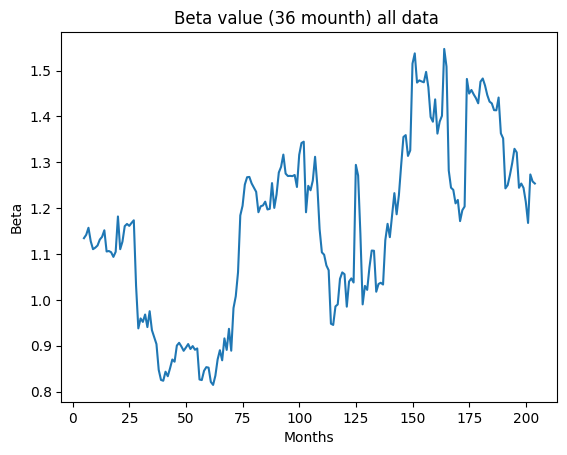

In [14]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [15]:
y_test

165    1.508843
166    1.282142
167    1.244670
168    1.239940
169    1.210486
170    1.217961
171    1.171809
172    1.195566
173    1.203631
174    1.481845
175    1.449904
176    1.457795
177    1.448283
178    1.439898
179    1.428745
180    1.475798
181    1.482826
182    1.467693
183    1.446758
184    1.432407
185    1.428525
186    1.413803
187    1.413474
188    1.441300
189    1.363122
190    1.352258
191    1.243156
192    1.250175
193    1.272412
194    1.298192
195    1.329498
196    1.321552
197    1.244439
198    1.253750
199    1.244269
200    1.213792
201    1.167748
202    1.273590
203    1.258297
204    1.253811
Name: target, dtype: float64

In [16]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [17]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [18]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 0s 2ms/step - loss: 1.6484
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 1.2392
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.9374
Epoch 4/200
16/16 [==============================] - 0s 1ms/step - loss: 0.6881
Epoch 5/200
16/16 [==============================] - 0s 1ms/step - loss: 0.4856
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3271
Epoch 7/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2094
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1301
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0851
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0601
Epoch 12/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 16ms/step


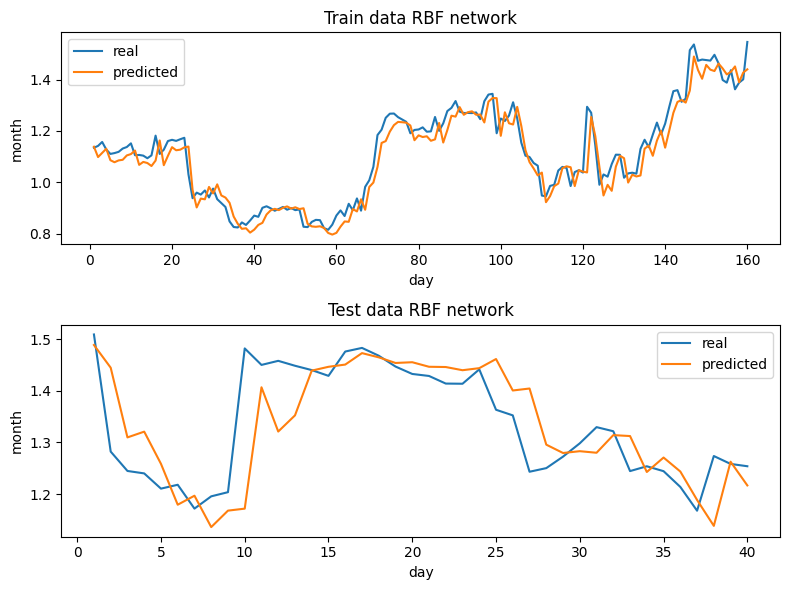

In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [20]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

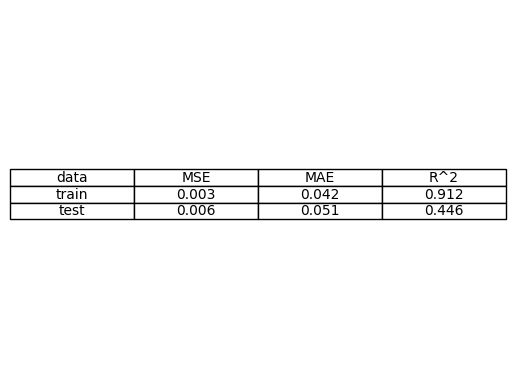

In [21]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [29]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

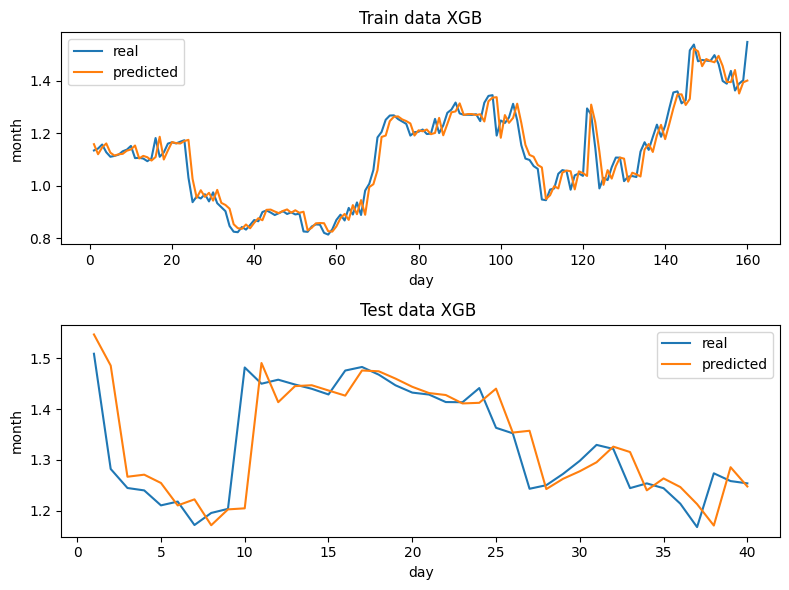

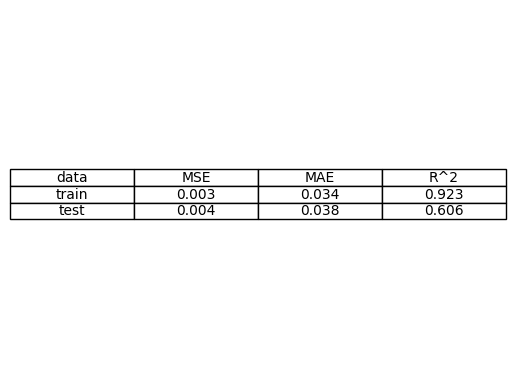

In [30]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 6ms/step - loss: 0.0725
Epoch 2/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0149
Epoch 3/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0148
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0144
Epoch 5/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0183
Epoch 6/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0137
Epoch 7/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0137
Epoch 8/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0119
Epoch 9/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0145
Epoch 10/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0107
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 12/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0114
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 5ms/step


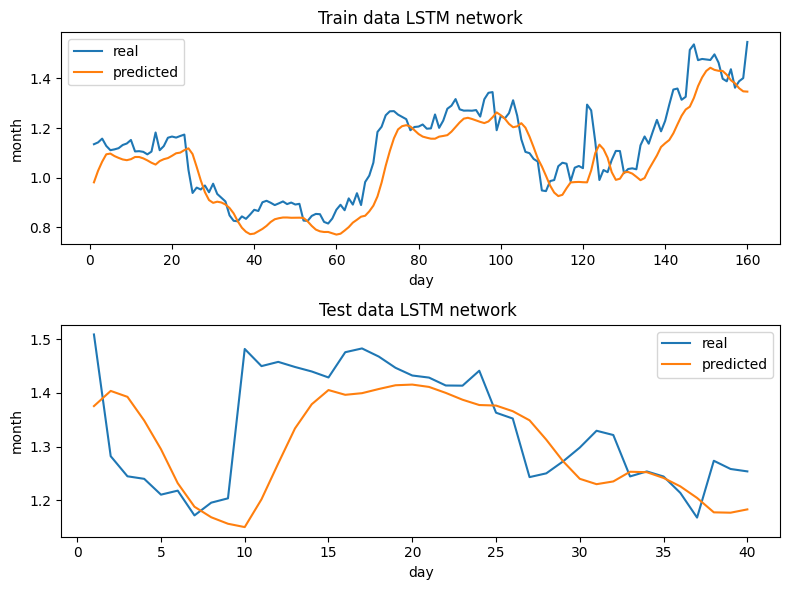

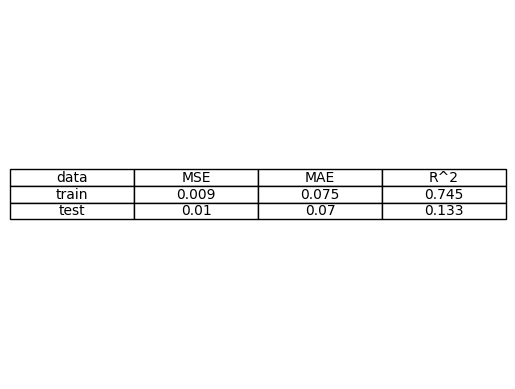

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

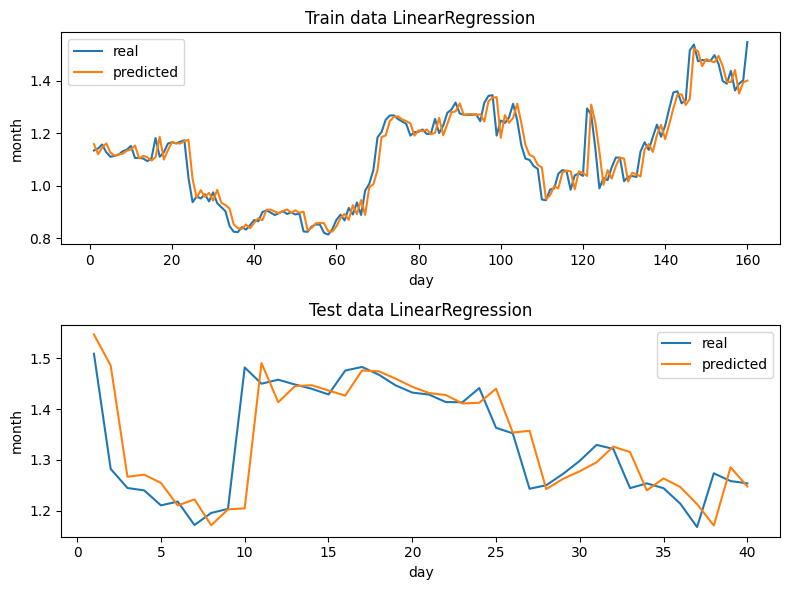

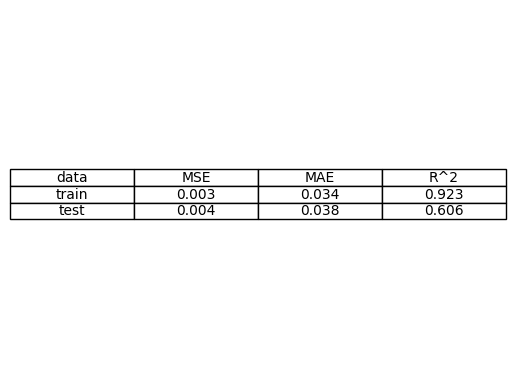

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')